In [193]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import sys,csv
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

# Citim fisierul CSV si inseram datele intr-o baza de date

In [2]:
path_csv = "./1_Source_Data/news_cleaned_2018_02_13.csv"

In [18]:
db.close()

In [19]:
db = sql.connect('./2_Database/fakenews.db')

In [4]:
def csv_field_limit():
    maxInt = sys.maxsize
    decrement = True

    while decrement:
        decrement = False
        try:
            csv.field_size_limit(maxInt)
        except OverflowError:
            maxInt = int(maxInt/10)
            decrement = True

In [5]:
csv_field_limit()

In [20]:
with tqdm() as progress:
    for articles in pd.read_csv(path_csv, engine='python', 
                                    chunksize=20000,
                                    encoding='utf8', 
                                    keep_default_na=False):
        try:
            articles.columns = [ column.replace(' ','_') for column in articles.columns]
            articles.to_sql('news' , db,if_exists = 'append')
            progress.update()
        except:
            continue

427it [25:10,  3.54s/it]


### Facem o interogare cu numarul de inregistrari din baza de date

In [21]:
pd.read_sql("SELECT COUNT(*) FROM NEWS", db)

,COUNT(*)
0,8529090


### Tipuri de stiri:
* bias
* clickbait
* conspiracy
* fake
* hate
* junksci
* political
* reliable
* rumor
* satire
* unknown
* unreliable

In [22]:
df = pd.read_sql('select type, count(*) as count from news group by type', db)

In [31]:
df.drop(df.index[[0,1,2]], inplace = True)

In [30]:
df.reset_index(drop=True, inplace = True)
df.set_index("type",inplace = True)
df

,count
type,
NaN,23
,403309
2018-02-10 13:43:39.521661,13
bias,1138998
clickbait,231949
conspiracy,831235
fake,894746
hate,76496
junksci,117467


In [32]:
df

,count
type,
bias,1138998
clickbait,231949
conspiracy,831235
fake,894746
hate,76496
junksci,117467
political,1657224
reliable,1913222
rumor,481158


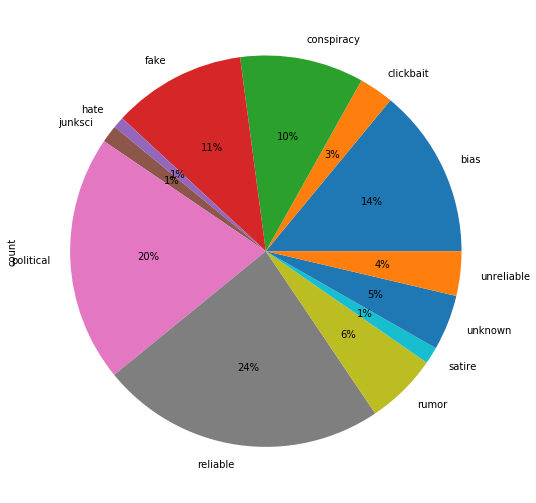

In [55]:
df.plot.pie(y='count',figsize = (9,9), autopct='%1.0f%%', legend = False)

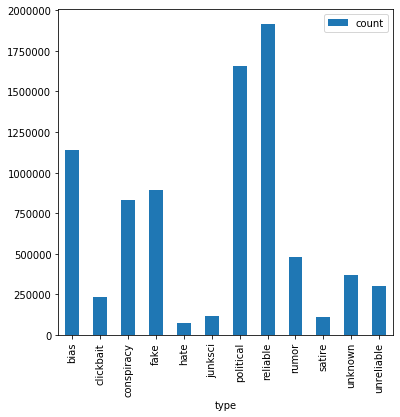

In [60]:
df.plot.bar(y='count',figsize = (6, 6))

In [56]:
df_by_domain = pd.read_sql('select domain, count(*) as count from news group by domain HAVING domain not like "%+%" and domain != "" ', db)

In [51]:
df_by_domain.reset_index(drop=True, inplace = True)
df_by_domain.set_index("domain",inplace = True)

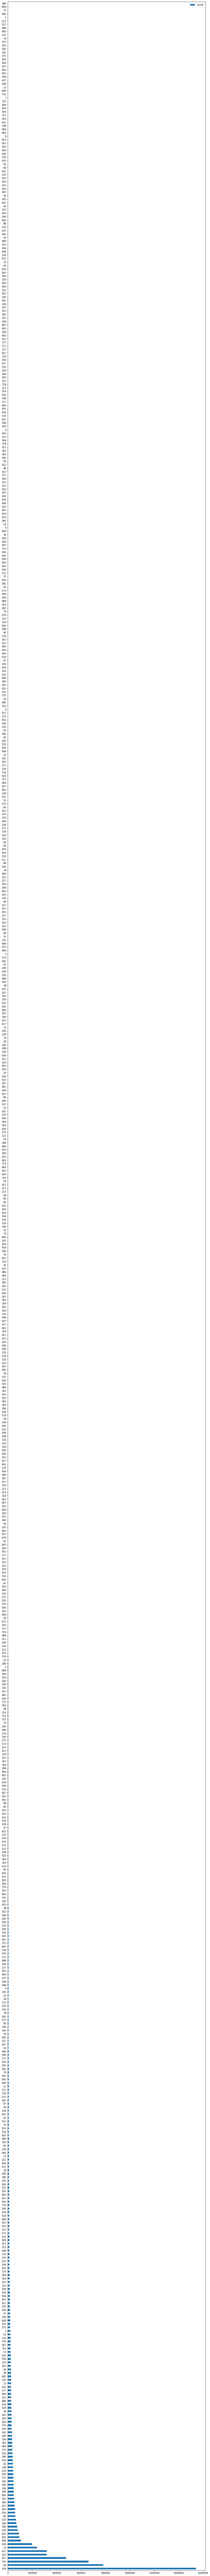

In [57]:
df_by_domain.sort_values(by ='count', ascending = False, inplace = True)
df_by_domain.plot.barh(y = 'count', figsize = (15,200))

In [62]:
fake_by_domain = pd.read_sql('select domain, count(*) as count from news group by domain having type = "fake" or type = "conspiracy" or type ="unreliable" ',db)
fake_by_domain.sort_values(by = 'count',ascending = False, inplace = True)
fake_by_domain

,domain,count
23,beforeitsnews.com,781009
7,abovetopsecret.com,238622
216,wikileaks.org,199031
217,wikispooks.com,80683
164,thedailysheeple.com,51321
...,...,...
24,bighairynews.com,1
132,politicalears.com,1
27,bostonleader.com,1
102,libertyalliance.com,1


In [519]:
reliable_by_domain = pd.read_sql('select domain, count(*) as count from news group by domain having type = "reliable"',db)
reliable_by_domain.sort_values(by = 'count',ascending = False, inplace = True)
reliable_by_domain

KeyboardInterrupt: 

In [521]:
reliable_by_domain.count()

count    80
dtype: int64

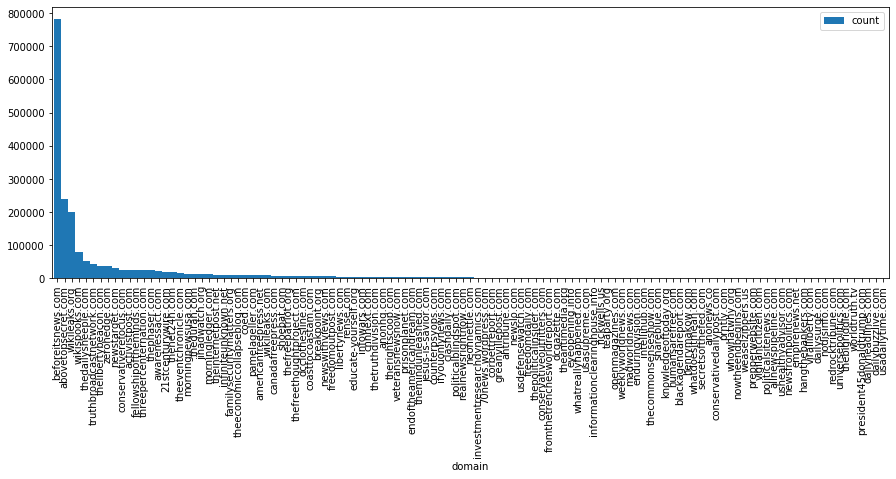

In [88]:
fake_by_domain[fake_by_domain['count'] > 200].plot.bar(y='count', figsize = (15,5), width=1)

In [91]:
reliable_by_domain.set_index("domain",inplace = True)

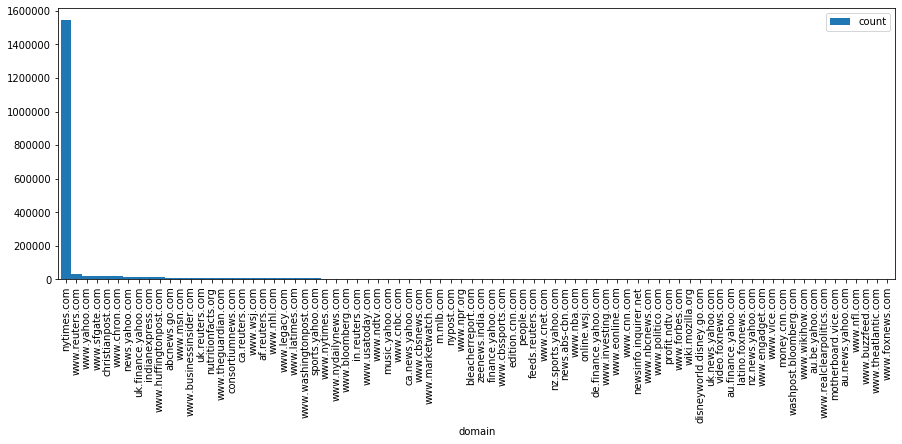

In [92]:
reliable_by_domain[reliable_by_domain['count'] > 200].plot.bar(y='count', figsize = (15,5), width=1)

### Vom crea o baza de date doar cu inregistrarile 'reliable' si 'fake' 
##### Vom considera inregistrarile fake urmatoarele:
* fake
* conspiracy
* unreliable

In [3]:
work_db = sql.connect('./2_Database/work_database_v1.db')

In [93]:
reliable = pd.read_sql('SELECT content, type FROM NEWS where type = "reliable" ',db)

In [5]:
reliable.drop(['index','Unnamed:_0','id','scraped_at','inserted_at',
               'updated_at', 'keywords', 'tags', 'summary', 'source', 'url'
              ], axis = 1,inplace = True)

In [522]:
reliable.count()

type      1913209
length    1913209
dtype: int64

In [95]:
reliable.isna().sum()

content    13
type        0
dtype: int64

In [96]:
reliable.dropna(axis = 0, how = 'any',inplace=True)

In [97]:
reliable.isna().sum()

content    0
type       0
dtype: int64

In [489]:
graf = reliable[(reliable['length']>0)].groupby('length').count()

In [490]:
graf = pd.DataFrame(graf.type)

In [491]:
graf.sort_values(by = 'type',ascending = False, inplace = True)

In [492]:
graf = graf.reset_index()

In [493]:
graf['count']=graf['type']

In [494]:
graf.drop(['type'], axis= 1, inplace =True)

In [495]:
graf['type'] = 'reliable'

In [417]:
graf = pd.concat([graf, graf1])

In [408]:
graf

,length,count,type
0,2314,797,reliable
1,819,715,reliable
2,1467,683,reliable
3,836,609,reliable
4,1573,601,reliable
...,...,...,...
28084,26115,1,fake
28085,26114,1,fake
28086,26111,1,fake
28087,26108,1,fake


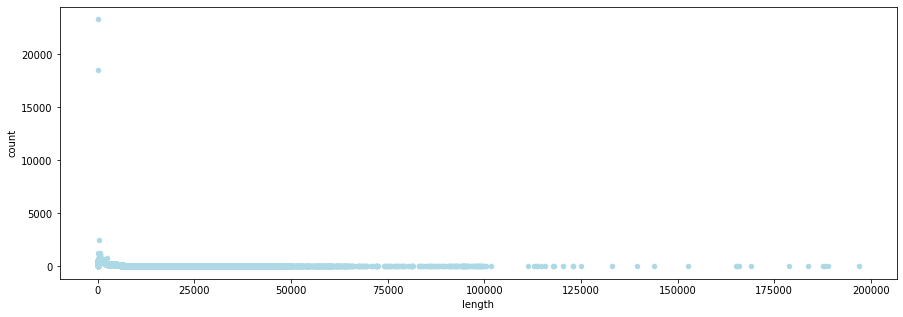

In [504]:
graf[:].plot.scatter(y='count',x = 'length', c="lightblue", legend =True, figsize = (15,5), sort_columns=True)

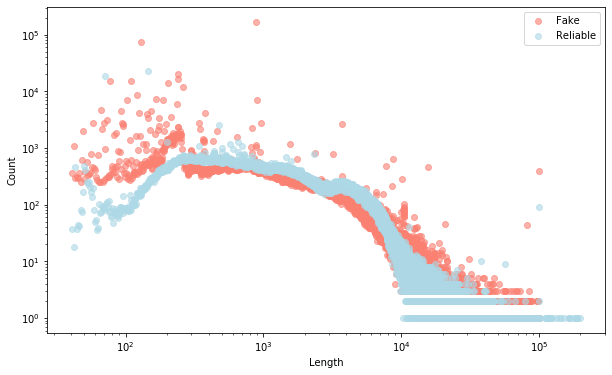

In [518]:
plt.figure(figsize=(10,6))
ax = plt.gca()
# Start with positve examples
plt.scatter(graf1.length[graf1.type=='fake'], 
            graf1['count'][graf1.type=='fake'], 
            c="salmon",
           alpha=0.6) # define it as a scatter figure

# Now for negative examples, we want them on the same plot, so we call plt again
plt.scatter(graf.length[graf.type=='reliable'], 
            graf['count'][graf.type=='reliable'], 
            c="lightblue",
           alpha=0.6) # d
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Length")
plt.legend(["Fake", "Reliable"])
plt.ylabel("Count");


In [358]:
graf['count'][graf.type=='fake']

0        169705
1          7155
2          2732
3          2647
4          2226
          ...  
28084         1
28085         1
28086         1
28087         1
28088         1
Name: count, Length: 28089, dtype: int64

In [10]:
reliable['sentiment'] = 0
reliable['magnitude'] = 0
reliable.head()

,domain,type,content,title,authors,meta_keywords,meta_description,sentiment,magnitude
0,christianpost.com,reliable,"Facebook/DestinyTheGame Promo image for ""Desti...",'Destiny 2' News: Bungie Addresses Player Comp...,,[''],"""Destiny 2's"" Faction Rallies was one of the m...",0,0
1,christianpost.com,reliable,"(Screenshot: Facebook) Dr. Melina Abdullah, pr...",Professor Conducts Libation to Summon Spirits ...,,[''],"Dr. Melina Abdullah, professor and chair of Pa...",0,0
2,christianpost.com,reliable,(Photo: Reuters) The teams of North and South ...,'Ghost Ship' With 8 Dead N. Koreans Washes Up ...,,[''],While news of North and South Korea agreeing t...,0,0
3,christianpost.com,reliable,(Photo: Reuters/Dado Ruvic) Facebook.\n\nUPDAT...,Facebook Lifts Ban on Paid Ads for Pro-Life Fi...,,[''],Facebook said Thursday that it has lifted its ...,0,0
4,christianpost.com,reliable,(Screencap: YouTube/Tidningen Dagen) Annahita ...,"Iranian Christian Convert Leads 1,500 Muslims ...",,[''],"An Iranian convert to Christianity, now an ord...",0,0


In [11]:
reliable.to_sql('news', work_db,if_exists = 'append')

In [268]:
unreliable = pd.read_sql('SELECT content,type FROM NEWS WHERE type ="fake" or type = "unreliable" or type = "conspiracy"',db)

In [14]:
unreliable.drop(['index','Unnamed:_0','id','scraped_at','inserted_at',
               'updated_at', 'keywords', 'tags', 'summary', 'source', 'url'
              ], axis = 1,inplace = True)

In [269]:
unreliable.isna().sum()

content    0
type       0
dtype: int64

In [270]:
unreliable['length'] = unreliable['content'].apply(len)

In [271]:
unreliable.drop(['content'],axis = 1,inplace=True)

In [528]:
unreliable.count()+reliable.count()

type      3937974
length    3937974
dtype: int64

In [497]:
graf1 = unreliable[(unreliable['length']>0)].groupby('length').count()

In [498]:
graf1 = pd.DataFrame(graf1.type)

In [499]:
graf1.sort_values(by = 'type',ascending = False, inplace = True)

In [500]:
graf1 = graf1.reset_index()

In [501]:
graf1['count']=graf1['type']

In [502]:
graf1.drop(['type'], axis= 1, inplace =True)

In [503]:
graf1['type'] = 'fake'

In [336]:
graf1

,length,count,type
0,879,169705,fake
1,900,7155,fake
2,954,2732,fake
3,3717,2647,fake
4,832,2226,fake
...,...,...,...
28084,26115,1,fake
28085,26114,1,fake
28086,26111,1,fake
28087,26108,1,fake


In [16]:
unreliable.to_sql('news', work_db,if_exists = 'append')

In [24]:
unreliable['sentiment'] = 0
unreliable['magnitude'] = 0

In [26]:
unreliable.to_sql('news', work_db,if_exists = 'replace')

In [21]:
work_db.close()

In [27]:
unreliable.head()

,domain,type,content,title,authors,meta_keywords,meta_description,sentiment,magnitude
0,blackgenocide.org,conspiracy,\n\n\n\n\n\n\n\nRev Dr. Childress is available...,BlackGenocide.org,,"['pro-life events', 'Clenard Childress', 'sche...",Find out when and where you can get involved w...,0,0
1,blackgenocide.org,conspiracy,\n\nSpeaking Engagement Request\n\n\n\nContact...,Request Speaking Engagement,,[''],,0,0
2,blackgenocide.org,conspiracy,"""…I have set before you life and death, blessi...",BlackGenocide.org,,"['planned parenthood', 'minorities', 'black cu...",The Negro Project is a devastating eugenic sta...,0,0
3,blackgenocide.org,conspiracy,Why We Oppose Planned Parent Hood ( The follow...,Why We Oppose Planned Parenthood,,"['planned parenthood', 'minorities', 'black cu...",A rationale for opposing the work of Planned P...,0,0
4,blackgenocide.org,conspiracy,If You Love The Children\n\nSaySo March 2014,SaySo March 2014,,[''],,0,0


In [32]:
reliable['sentiment'] = 0
reliable['magnitude'] = 0
reliable.head()

,domain,type,content,title,authors,meta_keywords,meta_description,sentiment,magnitude
0,christianpost.com,reliable,"Facebook/DestinyTheGame Promo image for ""Desti...",'Destiny 2' News: Bungie Addresses Player Comp...,,[''],"""Destiny 2's"" Faction Rallies was one of the m...",0,0
1,christianpost.com,reliable,"(Screenshot: Facebook) Dr. Melina Abdullah, pr...",Professor Conducts Libation to Summon Spirits ...,,[''],"Dr. Melina Abdullah, professor and chair of Pa...",0,0
2,christianpost.com,reliable,(Photo: Reuters) The teams of North and South ...,'Ghost Ship' With 8 Dead N. Koreans Washes Up ...,,[''],While news of North and South Korea agreeing t...,0,0
3,christianpost.com,reliable,(Photo: Reuters/Dado Ruvic) Facebook.\n\nUPDAT...,Facebook Lifts Ban on Paid Ads for Pro-Life Fi...,,[''],Facebook said Thursday that it has lifted its ...,0,0
4,christianpost.com,reliable,(Screencap: YouTube/Tidningen Dagen) Annahita ...,"Iranian Christian Convert Leads 1,500 Muslims ...",,[''],"An Iranian convert to Christianity, now an ord...",0,0


In [33]:
df = pd.concat([reliable,unreliable])

In [34]:
df.head()

,domain,type,content,title,authors,meta_keywords,meta_description,sentiment,magnitude
0,christianpost.com,reliable,"Facebook/DestinyTheGame Promo image for ""Desti...",'Destiny 2' News: Bungie Addresses Player Comp...,,[''],"""Destiny 2's"" Faction Rallies was one of the m...",0,0
1,christianpost.com,reliable,"(Screenshot: Facebook) Dr. Melina Abdullah, pr...",Professor Conducts Libation to Summon Spirits ...,,[''],"Dr. Melina Abdullah, professor and chair of Pa...",0,0
2,christianpost.com,reliable,(Photo: Reuters) The teams of North and South ...,'Ghost Ship' With 8 Dead N. Koreans Washes Up ...,,[''],While news of North and South Korea agreeing t...,0,0
3,christianpost.com,reliable,(Photo: Reuters/Dado Ruvic) Facebook.\n\nUPDAT...,Facebook Lifts Ban on Paid Ads for Pro-Life Fi...,,[''],Facebook said Thursday that it has lifted its ...,0,0
4,christianpost.com,reliable,(Screencap: YouTube/Tidningen Dagen) Annahita ...,"Iranian Christian Convert Leads 1,500 Muslims ...",,[''],"An Iranian convert to Christianity, now an ord...",0,0


In [35]:
df.sample(frac = 1)

,domain,type,content,title,authors,meta_keywords,meta_description,sentiment,magnitude
1081962,beforeitsnews.com,fake,How to Encourage Creativity in Your Child\n\n(...,How to Encourage Creativity in Your Child,Ed That Matters,[''],,0,0
157143,wikispooks.com,conspiracy,"""Has subobject"" is a predefined property repre...",W. Neil Eggleston,,[''],,0,0
1221610,nytimes.com,reliable,Democrats and officials with Acorn accuse Repu...,Group’s Tally of New Voters Was Vastly Overstated,"Michael Falcone, Michael Moss","['Voter Registration and Requirements', 'Assoc...",Republicans have seized on the disclosure that...,0,0
1045438,beforeitsnews.com,fake,"(CRWE, NBR, HLF, CLH) Stock in Focus by CRWEWa...","(CRWE, NBR, HLF, CLH) Stock in Focus by CRWEWa...",,[''],,0,0
988240,nytimes.com,reliable,"''YOU'VE got to do it,'' my brother-in-law Wil...",Spare the Box Step and Spoil the Child,,"['Dancing', 'Children and Youth', 'La Gorce T...","''YOU'VE got to do it,'' my brother-in-law Wil...",0,0
...,...,...,...,...,...,...,...,...,...
1647697,nytimes.com,reliable,"Looking to future sources of new revenue, Eske...",The Unlobbyists,Thomas B. Edsall,"['Lobbying and Lobbyists', 'Campaign Finance',...",A new breed of strategic adviser offers a full...,0,0
1777101,wikileaks.org,unreliable,Tor\n\nTor is an encrypted anonymising network...,Cable: 1976MANILA08520,,[''],,0,0
1007905,nytimes.com,reliable,"RUSSO--Miriam, 78, untimely passing on October...","Paid Notice: Deaths RUSSO, MIRIAM",,['RUSSO MIRIAM'],"RUSSO--Miriam, 78, untimely passing on October...",0,0
480801,abovetopsecret.com,conspiracy,"They said apparently there was a ""chunk"" of al...",toxic ash cloud heading for se portland oregon...,,[''],,0,0
